<a href="https://colab.research.google.com/github/ashmeenkhaira/Crop-cycle-shift-using-Remote-sensing-data/blob/main/paddy_88_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("=== Crop Sowing/Harvesting Prediction using LSTM ===")
print("Analysis for Patiala +100km region (2019-2024)")
print("=" * 50)

=== Crop Sowing/Harvesting Prediction using LSTM ===
Analysis for Patiala +100km region (2019-2024)


In [2]:
ndvi_file_path = "/content/Patiala_Weekly_NDVI_2019_2024.csv"
weather_file_path = "/content/Patiala_Weekly_Climate_2019_2024.csv"
ndvi_data = pd.read_csv(ndvi_file_path)
print(f"NDVI data shape: {ndvi_data.shape}")
print(f"NDVI columns: {ndvi_data.columns.tolist()}")
weather_data = pd.read_csv(weather_file_path)
print(f"Weather data shape: {weather_data.shape}")
print(f"Weather columns: {weather_data.columns.tolist()}")

NDVI data shape: (313, 4)
NDVI columns: ['system:index', 'ndvi_mean', 'week_start', '.geo']
Weather data shape: (313, 5)
Weather columns: ['system:index', 'rainfall_mm', 'temp_C', 'week_start', '.geo']


In [3]:
#data preprocessing
# Convert week_start columns to datetime
ndvi_data['week_start'] = pd.to_datetime(ndvi_data['week_start'], format='%Y-%m-%d')
weather_data['week_start'] = pd.to_datetime(weather_data['week_start'], format='%Y-%m-%d')

print(f"NDVI date range: {ndvi_data['week_start'].min()} to {ndvi_data['week_start'].max()}")
print(f"Weather date range: {weather_data['week_start'].min()} to {weather_data['week_start'].max()}")
merged_data = pd.merge(ndvi_data, weather_data, on='week_start', how='inner', suffixes=('_ndvi', '_weather'))
merged_data.set_index('week_start', inplace=True)
merged_data = merged_data.sort_index()

print(f"Merged data shape: {merged_data.shape}")
print(f"Final date range: {merged_data.index.min()} to {merged_data.index.max()}")
print(f"Total weeks of data: {len(merged_data)}")
print("\nSample of merged data:")
print(merged_data.head())
print(f"\nColumn names: {merged_data.columns.tolist()}")

#STEP 3: FEATURE ENGINEERING
data = merged_data.copy()
data['ndvi_ma4'] = data['ndvi_mean'].rolling(window=4, min_periods=1).mean()
data['ndvi_ma8'] = data['ndvi_mean'].rolling(window=8, min_periods=1).mean()
data['ndvi_ma12'] = data['ndvi_mean'].rolling(window=12, min_periods=1).mean()
data['ndvi_change'] = data['ndvi_mean'].diff()
data['ndvi_change_rate'] = data['ndvi_mean'].pct_change()
data['ndvi_std4'] = data['ndvi_mean'].rolling(window=4, min_periods=1).std()


NDVI date range: 2019-01-01 00:00:00 to 2024-12-24 00:00:00
Weather date range: 2019-01-01 00:00:00 to 2024-12-24 00:00:00
Merged data shape: (313, 7)
Final date range: 2019-01-01 00:00:00 to 2024-12-24 00:00:00
Total weeks of data: 313

Sample of merged data:
            system:index_ndvi  ndvi_mean  \
week_start                                 
2019-01-01                  0   0.523874   
2019-01-08                  1   0.668739   
2019-01-15                  2        NaN   
2019-01-22                  3   0.724466   
2019-01-29                  4   0.707964   

                                         .geo_ndvi  system:index_weather  \
week_start                                                                 
2019-01-01  {"type":"MultiPoint","coordinates":[]}                     0   
2019-01-08  {"type":"MultiPoint","coordinates":[]}                     1   
2019-01-15  {"type":"MultiPoint","coordinates":[]}                     2   
2019-01-22  {"type":"MultiPoint","coordinates":[]}

In [4]:
 #Handle infinite values from pct_change
data['ndvi_change_rate'] = data['ndvi_change_rate'].replace([np.inf, -np.inf], np.nan)

data['ndvi_above_ma8'] = (data['ndvi_mean'] > data['ndvi_ma8']).astype(int)
data['ndvi_peak_detection'] = ((data['ndvi_mean'] > data['ndvi_ma8']) & (data['ndvi_change'] > 0)).astype(int)
data['ndvi_decline_detection'] = ((data['ndvi_mean'] < data['ndvi_ma8']) & (data['ndvi_change'] < 0)).astype(int)

# Normalize NDVI
data['ndvi_normalized'] = (data['ndvi_mean'] - data['ndvi_mean'].min()) / (data['ndvi_mean'].max() - data['ndvi_mean'].min())

# Rainfall features
data['rainfall_ma4'] = data['rainfall_mm'].rolling(window=4, min_periods=1).mean()
data['rainfall_ma8'] = data['rainfall_mm'].rolling(window=8, min_periods=1).mean()
data['rainfall_cumulative_12w'] = data['rainfall_mm'].rolling(window=12, min_periods=1).sum()
data['rainfall_cumulative_4w'] = data['rainfall_mm'].rolling(window=4, min_periods=1).sum()
data['rainfall_intensity'] = data['rainfall_mm'].rolling(window=4, min_periods=1).std()

# Dry/wet period indicators
data['dry_period'] = (data['rainfall_mm'] < data['rainfall_mm'].quantile(0.25)).astype(int)
data['wet_period'] = (data['rainfall_mm'] > data['rainfall_mm'].quantile(0.75)).astype(int)

# Temperature features
data['temp_ma4'] = data['temp_C'].rolling(window=4, min_periods=1).mean()
data['temp_ma8'] = data['temp_C'].rolling(window=8, min_periods=1).mean()
data['temp_range_4w'] = data['temp_C'].rolling(window=4, min_periods=1).max() - data['temp_C'].rolling(window=4, min_periods=1).min()
data['temp_std4'] = data['temp_C'].rolling(window=4, min_periods=1).std()


In [5]:
# Growing degree days
data['gdd_wheat'] = np.maximum(data['temp_C'] - 10, 0)  # Base 10°C for wheat
data['gdd_paddy'] = np.maximum(data['temp_C'] - 15, 0)  # Base 15°C for paddy
data['gdd_wheat_cumulative'] = data['gdd_wheat'].rolling(window=12, min_periods=1).sum()
data['gdd_paddy_cumulative'] = data['gdd_paddy'].rolling(window=12, min_periods=1).sum()

# Temperature stress indicators
data['heat_stress'] = (data['temp_C'] > data['temp_C'].quantile(0.9)).astype(int)
data['cold_stress'] = (data['temp_C'] < data['temp_C'].quantile(0.1)).astype(int)

# Seasonal features
data['week_of_year'] = data.index.isocalendar().week
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['day_of_year'] = data.index.dayofyear

In [6]:
# Cyclical features for seasonality
data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Crop season indicators for Punjab region
data['wheat_season'] = ((data['month'] >= 11) | (data['month'] <= 4)).astype(int)
data['paddy_season'] = ((data['month'] >= 5) & (data['month'] <= 10)).astype(int)
data['monsoon_season'] = ((data['month'] >= 6) & (data['month'] <= 9)).astype(int)
data['winter_season'] = ((data['month'] >= 12) | (data['month'] <= 2)).astype(int)

# Fill NaN values
data = data.fillna(method='ffill').fillna(method='bfill')

print(f"Data shape after feature engineering: {data.shape}")
new_features = len([col for col in data.columns if any(suffix in col for suffix in ['_ma', '_cumulative', '_gdd', '_sin', '_cos', '_season', '_stress', '_period', '_detection', '_change', '_rate', '_normalized', '_above', '_std'])])
print(f"Created {new_features} new features")

Data shape after feature engineering: (313, 46)
Created 31 new features


In [7]:
#STEP 4: CREATE CROP STAGE LABELS
data['wheat_stage'] = 0  # 0: fallow, 1: sowing, 2: growing, 3: harvesting
data['paddy_stage'] = 0

# Wheat crop cycle (Nov-Apr in Punjab)
wheat_mask = data['wheat_season'] == 1
if wheat_mask.sum() > 0:
    wheat_data = data[wheat_mask]

    # Wheat stage conditions
    sowing_condition = (wheat_data['ndvi_mean'] > wheat_data['ndvi_mean'].quantile(0.2)) & \
                      (wheat_data['ndvi_change'] > 0) & \
                      (wheat_data['month'].isin([11, 12]))

    growing_condition = (wheat_data['ndvi_mean'] > wheat_data['ndvi_mean'].quantile(0.6)) & \
                       (wheat_data['month'].isin([1, 2, 3]))

    harvesting_condition = (wheat_data['ndvi_mean'] > wheat_data['ndvi_mean'].quantile(0.4)) & \
                          (wheat_data['ndvi_change'] < 0) & \
                          (wheat_data['month'].isin([3, 4]))

    # Apply wheat stage labels
    data.loc[wheat_mask & sowing_condition, 'wheat_stage'] = 1
    data.loc[wheat_mask & growing_condition, 'wheat_stage'] = 2
    data.loc[wheat_mask & harvesting_condition, 'wheat_stage'] = 3

# Paddy crop cycle (May-Oct in Punjab)
paddy_mask = data['paddy_season'] == 1
if paddy_mask.sum() > 0:
    paddy_data = data[paddy_mask]

    # Paddy stage conditions
    sowing_condition = (paddy_data['ndvi_mean'] > paddy_data['ndvi_mean'].quantile(0.2)) & \
                      (paddy_data['ndvi_change'] > 0) & \
                      (paddy_data['month'].isin([5, 6]))

    growing_condition = (paddy_data['ndvi_mean'] > paddy_data['ndvi_mean'].quantile(0.6)) & \
                       (paddy_data['month'].isin([7, 8, 9]))

    harvesting_condition = (paddy_data['ndvi_mean'] > paddy_data['ndvi_mean'].quantile(0.4)) & \
                          (paddy_data['ndvi_change'] < 0) & \
                          (paddy_data['month'].isin([9, 10]))

    # Apply paddy stage labels
    data.loc[paddy_mask & sowing_condition, 'paddy_stage'] = 1
    data.loc[paddy_mask & growing_condition, 'paddy_stage'] = 2
    data.loc[paddy_mask & harvesting_condition, 'paddy_stage'] = 3

print(f"Wheat stage distribution: {data['wheat_stage'].value_counts().sort_index()}")
print(f"Paddy stage distribution: {data['paddy_stage'].value_counts().sort_index()}")


Wheat stage distribution: wheat_stage
0    217
1     30
2     44
3     22
Name: count, dtype: int64
Paddy stage distribution: paddy_stage
0    222
1     15
2     40
3     36
Name: count, dtype: int64


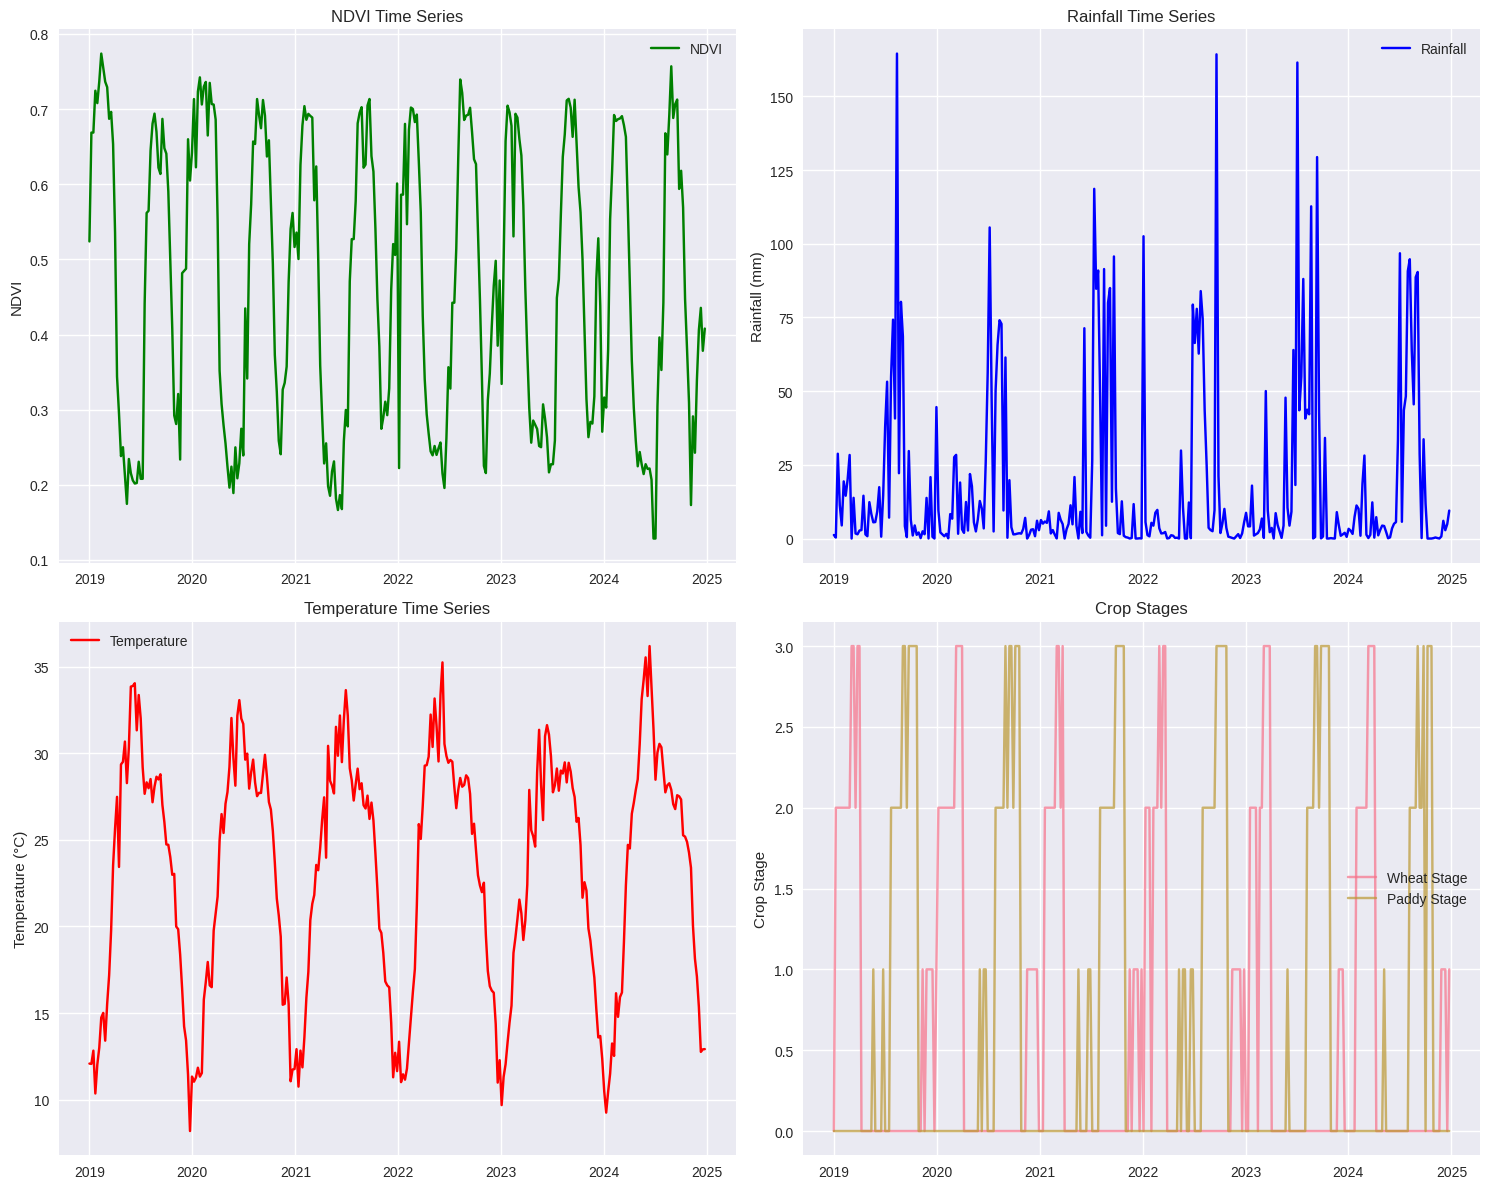

In [8]:
# Create visualizations for exploratory data analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# NDVI time series
axes[0, 0].plot(data.index, data['ndvi_mean'], label='NDVI', color='green')
axes[0, 0].set_title('NDVI Time Series')
axes[0, 0].set_ylabel('NDVI')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Rainfall time series
axes[0, 1].plot(data.index, data['rainfall_mm'], label='Rainfall', color='blue')
axes[0, 1].set_title('Rainfall Time Series')
axes[0, 1].set_ylabel('Rainfall (mm)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Temperature time series
axes[1, 0].plot(data.index, data['temp_C'], label='Temperature', color='red')
axes[1, 0].set_title('Temperature Time Series')
axes[1, 0].set_ylabel('Temperature (°C)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Crop stages
axes[1, 1].plot(data.index, data['wheat_stage'], label='Wheat Stage', alpha=0.7)
axes[1, 1].plot(data.index, data['paddy_stage'], label='Paddy Stage', alpha=0.7)
axes[1, 1].set_title('Crop Stages')
axes[1, 1].set_ylabel('Crop Stage')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

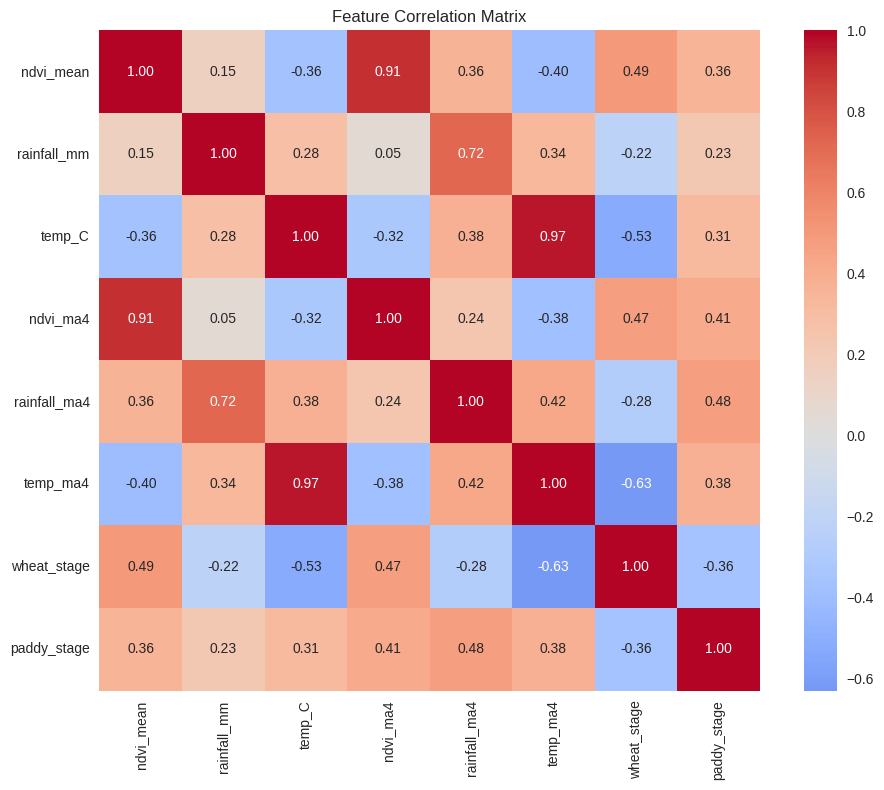

In [9]:
# Correlation heatmap for key features
key_features = ['ndvi_mean', 'rainfall_mm', 'temp_C', 'ndvi_ma4', 'rainfall_ma4', 'temp_ma4', 'wheat_stage', 'paddy_stage']
correlation_matrix = data[key_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [10]:
target_crop = 'paddy'
print(f"Preparing data for {target_crop} prediction...")
feature_columns = []
ndvi_features = [col for col in data.columns if 'ndvi' in col.lower() and 'detection' not in col.lower() and '.geo' not in col.lower()]
feature_columns.extend(ndvi_features)
weather_features = [col for col in data.columns if any(x in col.lower() for x in ['rain', 'temp', 'degree']) and '.geo' not in col.lower()]
feature_columns.extend(weather_features)
seasonal_features = [col for col in data.columns if col in ['week_of_year', 'month', 'quarter', 'day_of_year', 'week_sin', 'week_cos', 'month_sin', 'month_cos']]
feature_columns.extend(seasonal_features)
season_features = [col for col in data.columns if any(x in col for x in ['wheat_season', 'paddy_season', 'monsoon_season', 'winter_season'])]
feature_columns.extend(season_features)
indicator_features = [col for col in data.columns if any(x in col.lower() for x in ['stress', 'period', 'above']) and 'stage' not in col.lower()]
feature_columns.extend(indicator_features)

Preparing data for paddy prediction...


In [11]:
# Exclude system columns
exclude_cols = ['.geo_ndvi', '.geo_weather', 'system:index_ndvi', 'system:index_weather']
feature_columns = [col for col in feature_columns if col not in exclude_cols]
feature_columns = sorted(list(set(feature_columns)))
target_column = f'{target_crop}_stage'

print(f"Selected features ({len(feature_columns)}): {feature_columns}")
print(f"Target: {target_column}")

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(data[feature_columns])
y_scaled = scaler_y.fit_transform(data[[target_column]])
scaled_data = pd.DataFrame(X_scaled, columns=feature_columns, index=data.index)
scaled_data[target_column] = y_scaled

Selected features (36): ['cold_stress', 'day_of_year', 'dry_period', 'heat_stress', 'monsoon_season', 'month', 'month_cos', 'month_sin', 'ndvi_above_ma8', 'ndvi_change', 'ndvi_change_rate', 'ndvi_ma12', 'ndvi_ma4', 'ndvi_ma8', 'ndvi_mean', 'ndvi_normalized', 'ndvi_std4', 'paddy_season', 'quarter', 'rainfall_cumulative_12w', 'rainfall_cumulative_4w', 'rainfall_intensity', 'rainfall_ma4', 'rainfall_ma8', 'rainfall_mm', 'temp_C', 'temp_ma4', 'temp_ma8', 'temp_range_4w', 'temp_std4', 'week_cos', 'week_of_year', 'week_sin', 'wet_period', 'wheat_season', 'winter_season']
Target: paddy_stage


In [12]:
import os
import random
import numpy as np
import tensorflow as tf

# Set random seed for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print(f"Global random seed set to: {seed_value}")

Global random seed set to: 42


In [13]:
sequence_length = 12  # 12 weeks
print(f"Creating sequences with length: {sequence_length}")

X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[feature_columns].iloc[i-sequence_length:i].values)
    y.append(scaled_data[target_column].iloc[i])

X, y = np.array(X), np.array(y)
print(f"Sequence shape: X={X.shape}, y={y.shape}")

Creating sequences with length: 12
Sequence shape: X=(301, 12, 36), y=(301,)


In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (210, 12, 36)
Validation set: (45, 12, 36)
Test set: (46, 12, 36)


In [15]:
input_shape = (sequence_length, len(feature_columns))
print(f"Building LSTM model with input shape: {input_shape}")

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(25, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("Model architecture:")
model.summary()

Building LSTM model with input shape: (12, 36)
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,876 (179.20 KB)

 Trainable params: 45,876 (179.20 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
epochs = 100
batch_size = 32
print(f"Training LSTM model for {epochs} epochs...")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training LSTM model for 100 epochs...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.8534 - mae: 0.7884 - val_loss: 0.7156 - val_mae: 0.7229 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5194 - mae: 0.5863 - val_loss: 0.3087 - val_mae: 0.4335 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3479 - mae: 0.4252 - val_loss: 0.1989 - val_mae: 0.3251 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2855 - mae: 0.3178 - val_loss: 0.2320 - val_mae: 0.3343 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3085 - mae: 0.2999 - val_loss: 0.2610 - val_mae: 0.3698 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2636 - mae: 0.3064 - val_loss: 0.2125 - val_mae: 0.3516 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2394 - mae: 0.2811 - val_loss: 0.1802 - val_mae: 0.3250 - lear

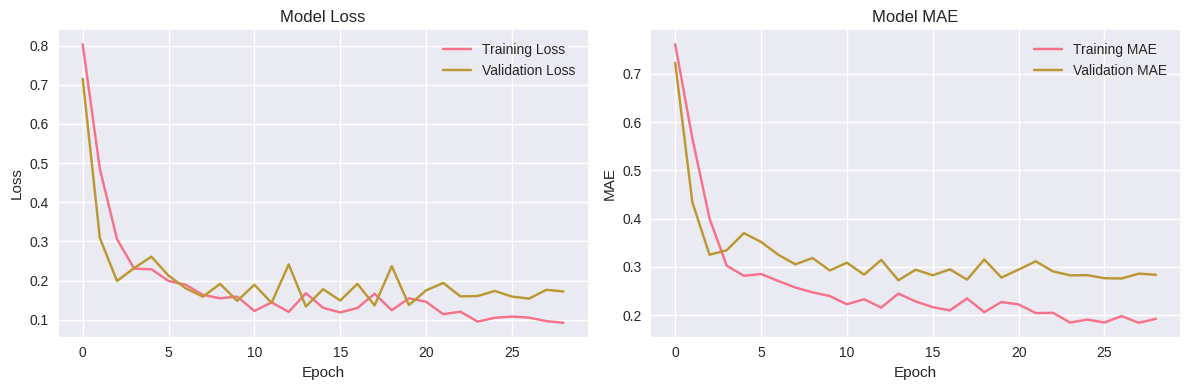

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
Mean Squared Error: 0.1702
Mean Absolute Error: 0.2648
R-squared Score: 0.8800


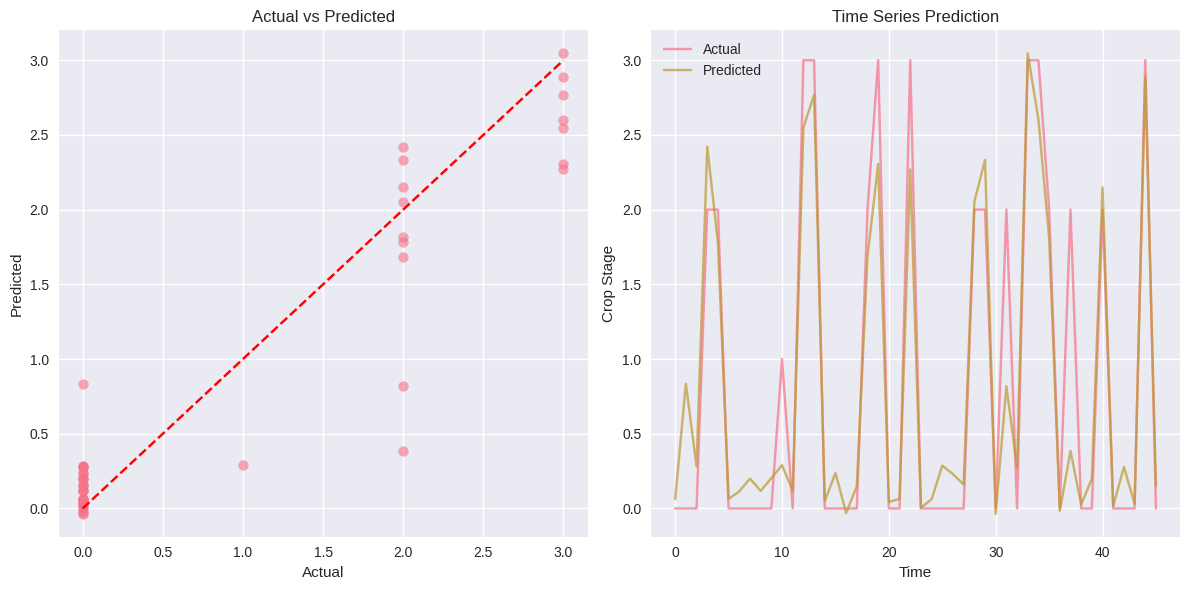

In [18]:
# Make predictions
y_pred = model.predict(X_test)

y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(y_test_original, label='Actual', alpha=0.7)
plt.plot(y_pred_original, label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Crop Stage')
plt.title('Time Series Prediction')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
# Prepare data for prediction
X_scaled_full = scaler_X.transform(data[feature_columns])

# Create sequences for prediction
X_sequences = []
for i in range(sequence_length, len(X_scaled_full)):
    X_sequences.append(X_scaled_full[i-sequence_length:i])
X_sequences = np.array(X_sequences)

# Make predictions
predictions = model.predict(X_sequences)
predictions_original = scaler_y.inverse_transform(predictions)

# Create results DataFrame
results = pd.DataFrame({
    'predicted_stage': predictions_original.flatten()
}, index=data.index[sequence_length:])

# Identify shifts in sowing/harvesting
results['stage_change'] = results['predicted_stage'].diff()
results['sowing_signal'] = (results['stage_change'] > 0.5).astype(int)
results['harvesting_signal'] = (results['stage_change'] < -0.5).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Prediction Summary:
Sowing signals detected: 9
Harvesting signals detected: 13


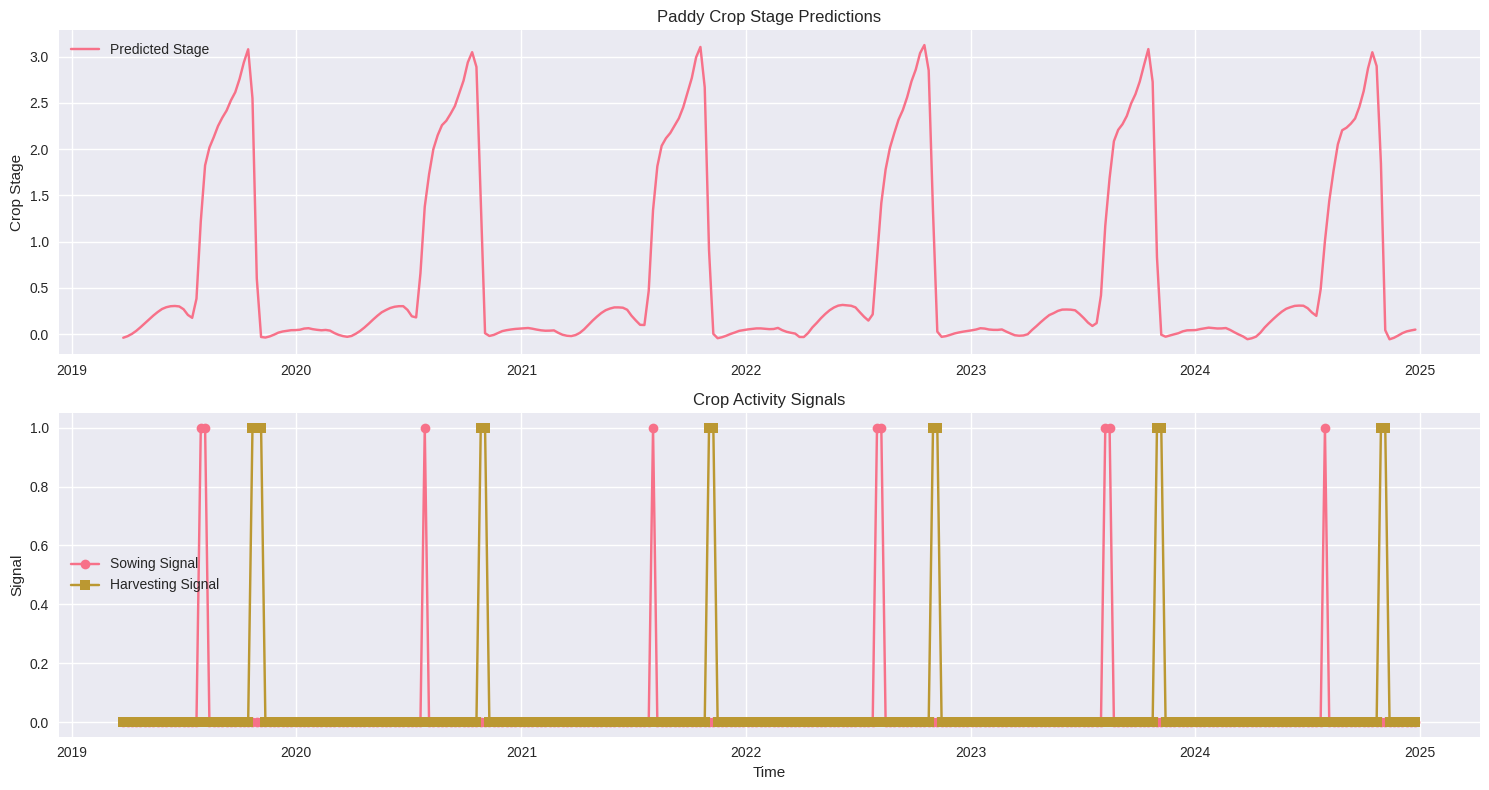

In [20]:
print("Prediction Summary:")
print(f"Sowing signals detected: {results['sowing_signal'].sum()}")
print(f"Harvesting signals detected: {results['harvesting_signal'].sum()}")

# Plot predictions
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(results.index, results['predicted_stage'], label='Predicted Stage')
plt.ylabel('Crop Stage')
plt.title(f'{target_crop.capitalize()} Crop Stage Predictions')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(results.index, results['sowing_signal'], label='Sowing Signal', marker='o')
plt.plot(results.index, results['harvesting_signal'], label='Harvesting Signal', marker='s')
plt.ylabel('Signal')
plt.xlabel('Time')
plt.title('Crop Activity Signals')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Save predictions
results.to_csv('paddy_predictions.csv')
print("paddy predictions saved to 'paddy_predictions.csv'")

paddy predictions saved to 'paddy_predictions.csv'


In [22]:
from datetime import datetime, timedelta
def input_year(operation_type):
    year1 = int(input(f"Enter first year for {operation_type} comparison: "))
    year2 = int(input(f"Enter second year for {operation_type} comparison: "))
    return year1, year2

def harvesting_periods(df, stage_col='predicted_stage', signal_col='harvesting_signal'):
    harvesting_periods = []
    harvest_signals = df[df[signal_col] == 1].copy()
    stage_transitions = df[df[stage_col].diff() < -0.3].copy()
    all_harvest_data = pd.concat([harvest_signals, stage_transitions]).drop_duplicates().sort_index()
    for date in all_harvest_data.index:
        month = date.month
        if month in [9, 10] and date in df.index:
            harvesting_periods.append({
                'date': date,
                'year': date.year,
                'month': date.month,
                'week': date.isocalendar()[1],
                'day_of_year': date.timetuple().tm_yday,
                'stage_value': df.loc[date, stage_col],
                'signal_value': df.loc[date, signal_col]
            })

    return pd.DataFrame(harvesting_periods)

def sowing_periods(df, stage_col='predicted_stage', signal_col='sowing_signal'):
    sowing_periods = []
    sow_signals = df[df[signal_col] == 1].copy()
    stage_transitions = df[df[stage_col].diff() > 0.3].copy()
    all_sow_data = pd.concat([sow_signals, stage_transitions]).drop_duplicates().sort_index()

    for date in all_sow_data.index:
        month = date.month
        if month in [5, 6] and date in df.index:
            sowing_periods.append({
                'date': date,
                'year': date.year,
                'month': date.month,
                'week': date.isocalendar()[1],
                'day_of_year': date.timetuple().tm_yday,
                'stage_value': df.loc[date, stage_col],
                'signal_value': df.loc[date, signal_col]
            })

    return pd.DataFrame(sowing_periods)

def year_range(df, year1, year2, operation_type):
    year_range = list(range(year1, year2 + 1))
    range_data = df[df['year'].isin(year_range)].copy()
    if len(range_data) == 0:
        print(f"No {operation_type} data found for years {year1}-{year2}")
        return None
    yearly_data = []
    for year in year_range:
        year_data = range_data[range_data['year'] == year]
        if len(year_data) > 0:
            primary_entry = year_data.iloc[0]
            yearly_data.append({
                'year': year,
                'date': primary_entry['date'],
                'day_of_year': primary_entry['day_of_year'],
                'week': primary_entry['week'],
                'stage_value': primary_entry['stage_value'],
                'signal_value': primary_entry['signal_value']
            })

    yearly_df = pd.DataFrame(yearly_data)
    if len(yearly_df) < 2:
        print(f"Need at least 2 years of data for comparison. Found {len(yearly_df)} years.")
        return None
    day_of_years = yearly_df['day_of_year'].values
    weeks = yearly_df['week'].values
    years_numeric = yearly_df['year'].values
    day_slope = np.polyfit(years_numeric, day_of_years, 1)[0]
    week_slope = np.polyfit(years_numeric, weeks, 1)[0]
    first_year_data = yearly_df.iloc[0]
    last_year_data = yearly_df.iloc[-1]

    total_day_shift = last_year_data['day_of_year'] - first_year_data['day_of_year']
    total_week_shift = last_year_data['week'] - first_year_data['week']
    years_span = year2 - year1
    avg_day_shift_per_year = total_day_shift / years_span if years_span > 0 else 0
    avg_week_shift_per_year = total_week_shift / years_span if years_span > 0 else 0
    if total_day_shift > 0:
        shift_direction = "Later"
    elif total_day_shift < 0:
        shift_direction = "Earlier"
    else:
        shift_direction = "Same"

    day_std = np.std(day_of_years)
    week_std = np.std(weeks)

    return {
        'from_year': year1,
        'to_year': year2,
        'years_analyzed': year_range,
        'yearly_data': yearly_df,
        'first_year_date': first_year_data['date'],
        'last_year_date': last_year_data['date'],
        'total_day_shift': total_day_shift,
        'total_week_shift': total_week_shift,
        'avg_day_shift_per_year': avg_day_shift_per_year,
        'avg_week_shift_per_year': avg_week_shift_per_year,
        'day_slope': day_slope,
        'week_slope': week_slope,
        'shift_direction': shift_direction,
        'shift_magnitude': abs(total_day_shift),
        'day_variability': day_std,
        'week_variability': week_std
    }

def comparison_results(comparison, operation_type):
    print(f"Analysis: {comparison['from_year']} to {comparison['to_year']} ({len(comparison['years_analyzed'])} years)")

    for _, row in comparison['yearly_data'].iterrows():
        print(f"  {int(row['year'])}: {row['date'].strftime('%Y-%m-%d')} (Day {int(row['day_of_year'])})")

    print(f"Total shift: {comparison['total_day_shift']:+.1f} days ({comparison['shift_direction']})")
    print(f"Average: {comparison['avg_day_shift_per_year']:+.1f} days/year")
    print(f"Trend: {comparison['day_slope']:+.2f} days/year")

    trend_strength = "strong" if abs(comparison['day_slope']) > 1 else "moderate" if abs(comparison['day_slope']) > 0.5 else "weak"
    print(f"{operation_type} shows {trend_strength} {comparison['shift_direction'].lower()} trend")

def analyze_harvesting_shifts(results):
    harvesting_df = harvesting_periods(results)
    if len(harvesting_df) == 0:
        print("No harvesting periods detected")
        harvest_months = results[results.index.month.isin([9, 10])].copy()
        harvest_months['year'] = harvest_months.index.year

        yearly_harvest = []
        for year in harvest_months['year'].unique():
            year_data = harvest_months[harvest_months['year'] == year]
            if len(year_data) > 0:
                max_harvest_idx = year_data['harvesting_signal'].idxmax()
                if pd.isna(max_harvest_idx) and not year_data.empty:
                    max_harvest_idx = year_data['predicted_stage'].idxmin()

                if max_harvest_idx is not None and max_harvest_idx in year_data.index:
                    yearly_harvest.append({
                        'date': max_harvest_idx,
                        'year': year,
                        'month': max_harvest_idx.month,
                        'week': max_harvest_idx.isocalendar()[1],
                        'day_of_year': max_harvest_idx.timetuple().tm_yday,
                        'stage_value': year_data.loc[max_harvest_idx, 'predicted_stage'],
                        'signal_value': year_data.loc[max_harvest_idx, 'harvesting_signal']
                    })

        harvesting_df = pd.DataFrame(yearly_harvest)

    print(f"Detected {len(harvesting_df)} paddy harvesting periods")

    if len(harvesting_df) == 0:
        print("No paddy harvesting periods detected.")
        return

    available_years = sorted(harvesting_df['year'].unique())
    print(f"\nAvailable years for paddy harvesting data: {available_years}")

    year1, year2 = input_year("paddy harvesting")
    comparison = year_range(harvesting_df, year1, year2, "paddy harvesting")

    if comparison is None:
        return

    comparison_results(comparison, "paddy harvesting")
    return comparison

def analyze_sowing_shifts(results):
    sowing_df = sowing_periods(results)

    if len(sowing_df) == 0:
        print("No sowing periods detected")
        sow_months = results[results.index.month.isin([5, 6])].copy()
        sow_months['year'] = sow_months.index.year

        yearly_sow = []
        for year in sow_months['year'].unique():
            year_data = sow_months[sow_months['year'] == year]
            if len(year_data) > 0:
                max_sow_idx = year_data['sowing_signal'].idxmax()
                if pd.isna(max_sow_idx) and not year_data.empty:
                    max_sow_idx = year_data['predicted_stage'].idxmax()

                if max_sow_idx is not None and max_sow_idx in year_data.index:
                    yearly_sow.append({
                        'date': max_sow_idx,
                        'year': year,
                        'month': max_sow_idx.month,
                        'week': max_sow_idx.isocalendar()[1],
                        'day_of_year': max_sow_idx.timetuple().tm_yday,
                        'stage_value': year_data.loc[max_sow_idx, 'predicted_stage'],
                        'signal_value': year_data.loc[max_sow_idx, 'sowing_signal']
                    })

        sowing_df = pd.DataFrame(yearly_sow)

    print(f"Detected {len(sowing_df)} paddy sowing periods")
    if len(sowing_df) == 0:
        print("No paddy sowing periods detected")
        return

    available_years = sorted(sowing_df['year'].unique())
    print(f"\nAvailable years for paddy sowing data: {available_years}")

    year1, year2 = input_year("paddy sowing")
    comparison = year_range(sowing_df, year1, year2, "paddy sowing")

    if comparison is None:
        return

    comparison_results(comparison, "paddy sowing")
    return comparison

if __name__ == "__main__":
    print("Choose analysis type:")
    print("1. Paddy harvesting shift analysis (September-October)")
    print("2. Paddy sowing shift analysis (May-June)")

    choice = input("\nEnter your choice (1/2): ")

    if choice == '1':
        harvest_comparison = analyze_harvesting_shifts(results)
    elif choice == '2':
        sowing_comparison = analyze_sowing_shifts(results)
    else:
        print("Invalid choice. Please run the script again.")

Choose analysis type:
1. Paddy harvesting shift analysis (September-October)
2. Paddy sowing shift analysis (May-June)

Enter your choice (1/2): 1
Detected 7 paddy harvesting periods

Available years for paddy harvesting data: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2023), np.int64(2024)]
Enter first year for paddy harvesting comparison: 2023
Enter second year for paddy harvesting comparison: 2024
Analysis: 2023 to 2024 (2 years)
  2023: 2023-10-24 (Day 297)
  2024: 2024-10-29 (Day 303)
Total shift: +6.0 days (Later)
Average: +6.0 days/year
Trend: +6.00 days/year
paddy harvesting shows strong later trend
